# Analysis of the connectivity of hydrides within themicrostructure of Zr alloys

###            Group 2: Jamie McGregor, Enn Veikesaar,  Wunmi Olukoya and Laura Gonzalez

## Aims

A program that can :
 
- `Upload`: an image of a micrograph 
- `Crop`: the image to only relevant area
- `Process`: Take scale bar to aid in comparison of images 
- `Process`: Identify indiviual Hydrides in microstructure  

## Import Packages

In [1]:
# We import the packages we need
from matplotlib import pyplot as plt
import re
from PIL import Image
import os, os.path
from os import listdir
import matplotlib.axes
import matplotlib.image as mpimg
import numpy as np
import cv2


# And also we import the functions we have created
from packages import Edge
from sorted_alphanumeric import sorted_aphanumeric
from split import vertical_strips
from blurring import blur

## Image loading

In this section the image is imported and loaded

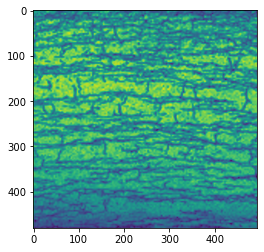

In [2]:
# The sorted_alphanumeric function loads the images and sorts them 

mypath = './Micrographs/'
def_files = sorted_aphanumeric(listdir(mypath))

# The data of the image that is going to be analised are storaged in the "img" variable
img = cv2.imread('./Micrographs/chu10.jpg',0)

# And the original image is plotted here
imgplot = plt.imshow(img)

## Image Processing

The images gained from the raw data is read with a BGR code through opencv instead of a RGB code. This doesn't matter as we will be transforming them into black and white images eventually. Due to the large area of the images being analysed, any standard connectivity methods will not work as every projection will have at least one hydride shadow. Therefore, we begin by breaking the image into vertical strips to reduce the interference on measuring the presence and continuity of radial hydrides. Following from this, we blur the strips and save them in their own directorys.

The function "vertical_strips" confirms that the total width of the image can be split into the defined number 
of sections (SecNum). If not, the number of slides will be increased by 1 until equality is achieved. And then, 
this function slices vertically the image in equal widths and return the number of strips.  

In [3]:
SecNum = 15 # Define an initial number of vertical strips 
strips=vertical_strips(SecNum,img) # We save the number of strips that we calculated with the vertical_strips function

The blur function applies blurring to the vertical strips to reduce the noise and transform them to grayscale. It also rejoin the strips to be able to plot the image we got so far   

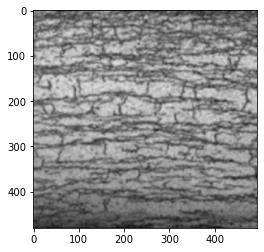

In [4]:
cv2.imwrite('ImagePrep/BlurJoined.png', blur(strips)) # The image returned from the blur function is stored as "BlurJoined"
plt.imshow(mpimg.imread('ImagePrep/BlurJoined.png')) # We plot the image we have so far to check the procedure

## Thresholding

This stage is to transform the image to be totally binary from the grayscale images saved and blured.
Use 3 different thresholding method and see which one works best .

Otsu method is first carried out.

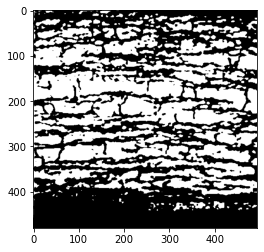

In [5]:
#using the tracker variable defined earlier, any actions can be repeated across the entirety of the slices easily
for i in range(strips):
    Blur = cv2.imread("./ImagePrep/Blurs/" + str(i) + ".png", 0)
#Using the inbuilt opencv otsu thresholding method and defining it as a binary threshold, aka only black and white, 
# both a thresholded image is produced and the automatically detected thresholding value is found.   
    ThreshValue, ThreshOtsu = cv2.threshold(Blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    cv2.imwrite("Thresholding/Otsu/" + str(i) +".png",ThreshOtsu)
    np.save("Thresholding/Otsu/" + str(i), ThreshOtsu)
    
#As earlier, the individual slices are saved to their own directory and an overall image is made from reattaching the slices.
    if i > 0:
        if i == 1:
            ImgL = cv2.imread("./Thresholding/Otsu/" + str(i-1) + ".png")
            ImgR = cv2.imread("./Thresholding/Otsu/" + str(i) + ".png")
            OtsuThresh = np.concatenate((ImgL, ImgR), axis=1)
        else:
            ImgR = cv2.imread("./Thresholding/Otsu/" + str(i) + ".png")
            OtsuThresh = np.concatenate((OtsuThresh, ImgR), axis=1)

cv2.imwrite('Thresholding/OtsuThresh.png', OtsuThresh) # The image returned from this function is stored as "OtsuThresh"

plt.imshow(mpimg.imread('Thresholding/OtsuThresh.png'))

Next k-means is attempted

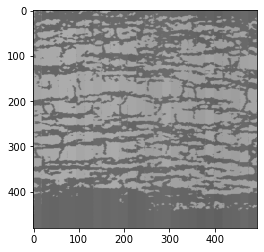

In [6]:
#As previously, the tracker variable is used to initiate the loop for the thresholding.
for i in range(strips):
    ImgIn = cv2.imread("./ImagePrep/Blurs/" + str(i) + ".png",1)
    
    Blur = cv2.cvtColor(ImgIn, cv2.COLOR_BGR2GRAY)

    reshapedImage = np.float32(Blur.reshape(-1, 3))

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.1)

#The number of channels is defined for the k-means method, as it's black and white "2" is chosen
    k = 2

    ret, labels, clusters = cv2.kmeans(reshapedImage, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    clusters = np.uint8(clusters)
    
    Sec = cv2.imread("./ImagePrep/Sections/" + str(i) + ".png")
    Sec = cv2.cvtColor(Sec,cv2.COLOR_BGR2GRAY)

    intermediateImage = clusters[labels.flatten()]
    clusteredImage = intermediateImage.reshape((Sec.shape))
    
    cv2.imwrite("Thresholding/Kmeans/" + str(i) +".png",clusteredImage)
    
#As earlier, the individual slices are saved to their own directory and an overall image is made from reattaching the slices.
    if i > 0:
        if i == 1:
            ImgL = cv2.imread("./Thresholding/Kmeans/" + str(i-1) + ".png")
            ImgR = cv2.imread("./Thresholding/Kmeans/" + str(i) + ".png")
            KThresh = np.concatenate((ImgL, ImgR), axis=1)
        else:
            ImgR = cv2.imread("./Thresholding/Kmeans/" + str(i) + ".png")
            KThresh = np.concatenate((KThresh, ImgR), axis=1)

cv2.imwrite("Thresholding/KThresh.png", KThresh) # The image returned from this function is stored as "KThresh"

plt.imshow(mpimg.imread('Thresholding/KThresh.png'))

## Connecivity of Microstructure 

Assess interconnectivity between hydrides in the radial direction. Using the literature review the formula for the HCC was discovered.

In [7]:
for i in range(strips):
    
    imgO = cv2.imread("./Thresholding/Otsu/" + str(i) + ".png", 0)
    imgK = cv2.imread("./Thresholding/Kmeans/" + str(i) + ".png", 0)
    
    CannyImgO = Edge.auto_canny(imgO)
    CannyImgK = Edge.auto_canny(imgK)
    
    cv2.imwrite("Edges/Otsu/" + str(i) +".png",CannyImgO) 
    cv2.imwrite("Edges/Kmeans/" + str(i) +".png",CannyImgO) 
    
    if i > 0:
        if i == 1:
            ImgL = cv2.imread("./Edges/Otsu/" + str(i-1) + ".png")
            ImgR = cv2.imread("./Edges/Otsu/" + str(i) + ".png")
            EdgesO = np.concatenate((ImgL, ImgR), axis=1)
            
            ImgL = cv2.imread("./Edges/Kmeans/" + str(i-1) + ".png")
            ImgR = cv2.imread("./Edges/Kmeans/" + str(i) + ".png")
            EdgesK = np.concatenate((ImgL, ImgR), axis=1)
        else:
            ImgR = cv2.imread("./Edges/Otsu/" + str(i) + ".png")
            EdgesO = np.concatenate((EdgesO, ImgR), axis=1)
            
            ImgR = cv2.imread("./Edges/Kmeans/" + str(i) + ".png")
            EdgesK = np.concatenate((EdgesK, ImgR), axis=1)

cv2.imwrite("Edges/CannyOtsu.png", EdgesO)
cv2.imwrite("Edges/CannyKmeans.png", EdgesK)        

True

In [8]:
imgO = cv2.imread("./Edges/CannyOtsu.png", 0)
imgK = cv2.imread("./Edges/CannyKmeans.png", 0)

HydrideOtsu = 0
HydrideKmeans = 0

HCC_Otsu =[]
HCC_Kmeans = []

for i in range(np.size(imgO,1)):
    for j in range(np.size(imgO,0)):
        if imgO[j,i] > 0:
            HydrideOtsu += 1
    HCC_Otsu.append(HydrideOtsu/(np.size(imgO,0)))
    HydrideOtsu = 0
    
for i in range(np.size(imgK,1)):
    for j in range(np.size(imgK,0)):
        if imgK[j,i] > 0:
            HydrideKmeans += 1
    HCC_Kmeans.append(HydrideKmeans/(np.size(imgK,0)))
    HydrideKmeans = 0

AVG_HCC_Otsu = sum(HCC_Otsu)/len(HCC_Otsu)
AVG_HCC_Kmeans = sum(HCC_Kmeans)/len(HCC_Kmeans)

print(AVG_HCC_Otsu, AVG_HCC_Kmeans)

0.09191126855600537 0.09191126855600537


This next method will be using the edge detection images to discover the contours within the slices then measure the HCC of the slices and averaging them across the image

In [9]:
HCCrun_Otsu = []
HCCrun_Kmeans = []

for i in range(strips):
    
    image_src_Otsu = cv2.imread("./Edges/Otsu/" + str(i) + ".png")

    gray = cv2.cvtColor(image_src_Otsu, cv2.COLOR_BGR2GRAY)
    ret, gray = cv2.threshold(gray, 250, 255,0)

    contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(image_src_Otsu.shape, np.uint8)
    largest_areas = sorted(contours, key=cv2.contourArea)
    cv2.drawContours(mask, [largest_areas[-1]], 0, (255,255,255,255), -1)
    removed = cv2.add(image_src_Otsu, mask)
    
    cv2.imwrite("Edges/ContOtsu/" + str(i) + ".png",removed) 
    
    cnts = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    y5 = []
    h5 = []
    
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        y5.append(y)
        h5.append(h)
     
    for r in range(len(y5)):
        g = y5[r] + h5[r]
        for j in range(len(y5)):
            if r < j:
                q = y5[j] + h5[j]
                if q > y5[r]:
                    z = q - y5[r]
                    q = q-z
                    h5[j] = h5[j] - z
    
    HCCrun_Otsu.append((sum(h5))/(np.size(image_src_Otsu,0)))
    
    del cnts
    
    image_src_Kmeans = cv2.imread("./Edges/Kmeans/" + str(i) + ".png")

    gray_k = cv2.cvtColor(image_src_Kmeans, cv2.COLOR_BGR2GRAY)
    ret, gray_k = cv2.threshold(gray_k, 250, 255,0)

    contours, hierarchy = cv2.findContours(gray_k, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(image_src_Kmeans.shape, np.uint8)
    largest_areas = sorted(contours, key=cv2.contourArea)
    cv2.drawContours(mask, [largest_areas[-1]], 0, (255,255,255,255), -1)
    removed = cv2.add(image_src_Kmeans, mask)
    
    cv2.imwrite("Edges/ContKmeans/" + str(i) + ".png",removed) 
    
    cnts = cv2.findContours(gray_k, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    y5 = []
    h5 = []
    
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        y5.append(y)
        h5.append(h)
     
    for r in range(len(y5)):
        g = y5[r] + h5[r]
        for j in range(len(y5)):
            if r < j:
                q = y5[j] + h5[j]
                if q > y5[r]:
                    z = q - y5[r]
                    q = q-z
                    h5[j] = h5[j] - z
    
    HCCrun_Kmeans.append((sum(h5))/(np.size(image_src_Kmeans,0))) 
    
    if i > 0:
        if i == 1:
            ImgL = cv2.imread("./Edges/ContOtsu/" + str(i-1) + ".png")
            ImgR = cv2.imread("./Edges/ContOtsu/" + str(i) + ".png")
            ContOtsu = np.concatenate((ImgL, ImgR), axis=1)
            
            ImgL = cv2.imread("./Edges/ContKmeans/" + str(i-1) + ".png")
            ImgR = cv2.imread("./Edges/ContKmeans/" + str(i) + ".png")
            ContKmeans = np.concatenate((ImgL, ImgR), axis=1)
        else:
            ImgR = cv2.imread("./Edges/ContOtsu/" + str(i) + ".png")
            ContOtsu = np.concatenate((ContOtsu, ImgR), axis=1)
            
            ImgR = cv2.imread("./Edges/ContKmeans/" + str(i) + ".png")
            ContKmeans = np.concatenate((ContKmeans, ImgR), axis=1)

print("Otsu HCC: " + str(sum(HCCrun_Otsu)/len(HCCrun_Otsu)))
print("K-means HCC: " + str(sum(HCCrun_Kmeans)/len(HCCrun_Kmeans)))
            
cv2.imwrite('Edges/ContOtsu.png',ContOtsu)
cv2.imwrite('Edges/ContKmeans.png',ContKmeans) 

Otsu HCC: 0.4733974358974359
K-means HCC: 0.4733974358974359


True